# Flow maximization problems

A _directed graph_ has the capacities on all the edges and our job is to find the maximum amount of flow that can happen from one node (starting node) to another node (outflow node). There are two types of flow maximization problems:

1. max flow: what is the maximum flow that can be sent from source to output without exceeding capacity
2. min-cost flow: we have the cost along the capacities on each edge. We want to find the minimum cost path of sending `f` units of flow from source to outflow


Both can be solved using integer programming.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

%matplotlib inline

## Maximum Flow Problem

In [2]:
edgelist_df = pd.DataFrame(
    {"node1": list("ssuuv"), "node2": list("uvvtt"), "weights": [20, 10, 30, 10, 20]}
)
edgelist_df

,node1,node2,weights
0,s,u,20
1,s,v,10
2,u,v,30
3,u,t,10
4,v,t,20


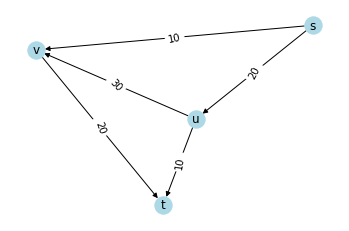

In [8]:
G = nx.from_pandas_edgelist(
    edgelist_df,
    source="node1",
    target="node2",
    edge_attr=["weights"],
    create_using=nx.DiGraph(),
)
nx.is_directed(G)

weights = nx.get_edge_attributes(G, "weights")
pos = nx.spring_layout(G)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=weights)
nx.draw(G, pos=pos, with_labels=True, node_color="lightblue")

Goal: We want to find the maximum flow between s and t. This can be formulated as an integer programming problem with _decision variable_
1. integer variable $edge_{i,j}$ representing the amount of flow in $edge_{i,j}$
2. integer variable $f$ representing the maximum flow 

In [9]:
from ortools.sat.python import cp_model

max_flow_model = cp_model.CpModel()

In [15]:
# Creating one integer decision variables for each edge.
edge_int_vars = {}
for edge in G.edges:
    edge_int_vars[edge[0], edge[1]] = max_flow_model.NewIntVar(
        0, 100, f"edge_{edge[0]}_{edge[1]}"
    )
    print(
        "Creating the integer variable",
        edge_int_vars[edge[0], edge[1]],
        "representing the amount to flow in edge",
        (edge[0], edge[1]),
    )

Creating the integer variable edge_s_u representing the amount to flow in edge ('s', 'u')
Creating the integer variable edge_s_v representing the amount to flow in edge ('s', 'v')
Creating the integer variable edge_u_v representing the amount to flow in edge ('u', 'v')
Creating the integer variable edge_u_t representing the amount to flow in edge ('u', 't')
Creating the integer variable edge_v_t representing the amount to flow in edge ('v', 't')


**Constraints**

The first set of constraints are flow constraints:

1. At the input node, the net flow should be -f 
2. At the output node, the net flow should be +f
3. The net flow in all other nodes should be 0

In [16]:
input_node = "s"
output_node = "t"

In [19]:
# Adding constraints on the nodes

# Initializing flow - this will be maximized later.
flow = max_flow_model.NewIntVar(0, 100, "flow")
for node in G.nodes:
    in_edges = G.in_edges(node)
    out_edges = G.out_edges(node)
    print("Adding the constraint on node", node)

    equation_at_this_edge = sum(
        edge_int_vars[edge[0], edge[1]] for edge in in_edges
    ) - sum(edge_int_vars[edge[0], edge[1]] for edge in out_edges)

    if node == input_node:
        max_flow_model.Add(equation_at_this_edge == -flow)
        print(equation_at_this_edge == -flow)
    elif node == output_node:
        max_flow_model.Add(equation_at_this_edge == flow)
        print(equation_at_this_edge == flow)
    else:
        max_flow_model.Add(equation_at_this_edge == 0)
        print(equation_at_this_edge == 0)
    print()

Adding the constraint on node s
((-(edge_s_u + edge_s_v) + 0) + (1 * flow)) == 0

Adding the constraint on node u
(edge_s_u + -(edge_u_v + edge_u_t)) == 0

Adding the constraint on node v
((edge_s_v + edge_u_v) + -edge_v_t) == 0

Adding the constraint on node t
((edge_u_t + edge_v_t) + -flow) == 0



Another set of constraints are the capacity restrictions on every edge.

In [25]:
# Adding constraints on the edges
for edge in G.edges:
    print("Adding constraint on edge", edge)
    max_flow_in_edge = G.get_edge_data(*edge)["weights"]
    max_flow_model.Add(edge_int_vars[edge[0], edge[1]] <= max_flow_in_edge)
    print(edge_int_vars[edge[0], edge[1]] <= max_flow_in_edge)
    print()

Adding constraint on edge ('s', 'u')
edge_s_u <= 20

Adding constraint on edge ('s', 'v')
edge_s_v <= 10

Adding constraint on edge ('u', 'v')
edge_u_v <= 30

Adding constraint on edge ('u', 't')
edge_u_t <= 10

Adding constraint on edge ('v', 't')
edge_v_t <= 20



**Objective**

The objective is to maximize flow

In [27]:
max_flow_model.Maximize(flow)

In [28]:
# Solving the problem
solver = cp_model.CpSolver()
solution_printer = cp_model.ObjectiveSolutionPrinter()
status = solver.SolveWithSolutionCallback(max_flow_model, solution_printer)

Solution 0, time = 0.01 s, objective = 30


In [29]:
status == cp_model.OPTIMAL

True

In [30]:
result_edges = {}
for edge in G.edges:
    result_edges[edge[0], edge[1]] = solver.Value(edge_int_vars[edge[0], edge[1]])
result_edges

{('s', 'u'): 20,
 ('s', 'v'): 10,
 ('u', 'v'): 10,
 ('u', 't'): 10,
 ('v', 't'): 20}

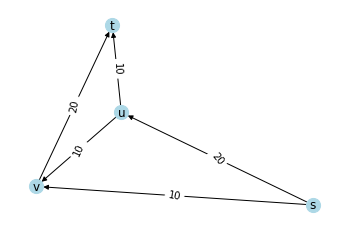

In [36]:
pos = nx.spring_layout(G)
props = dict(node_color="lightblue", node_size=200)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=result_edges)
nx.draw(G, pos=pos, with_labels=True, **props)

# Min cost flow problem

We want to find the minimum cost to transfer a fixed amount of flow from one edge to another. The costs are given in the table below. The costs are also displayed in the network below.

In [37]:
edgelist_df = pd.DataFrame(
    {
        "node1": list("ssuuv"),
        "node2": list("uvvtt"),
        "weights": [20, 10, 30, 10, 20],
        "costs": [3, 2, 0.7, 1, 7],
    }
)
edgelist_df

,node1,node2,weights,costs
0,s,u,20,3.0
1,s,v,10,2.0
2,u,v,30,0.7
3,u,t,10,1.0
4,v,t,20,7.0


In [40]:
G = nx.from_pandas_edgelist(
    edgelist_df,
    source="node1",
    target="node2",
    edge_attr=["weights", "costs"],
    create_using=nx.DiGraph(),
)
nx.is_directed(G)

True

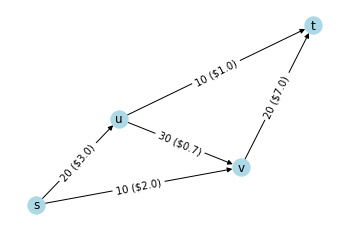

In [44]:
weights = nx.get_edge_attributes(G, "weights")
costs = nx.get_edge_attributes(G, "costs")
edge_labels = {k: "{} (${})".format(weights[k], costs[k]) for k in weights}

pos = nx.spring_layout(G)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
nx.draw(G, pos=pos, with_labels=True, node_color="lightblue")

We can use integer programming to find out the solution in this scenario 

**Decision variables**
Integer variables $edge_{i,j}$ representing the amount of flow in $edge_{i, j}$

**Constraints**
Capacity restriction on every edge

**Objective**
The objective is to minimize the overall cost

In [45]:
from ortools.sat.python import cp_model

min_cost_flow_model = cp_model.CpModel()

In [46]:
# Creating one integer decision variables for each edge
edge_int_vars = {}

for edge in G.edges:
    edge_int_vars[edge[0], edge[1]] = min_cost_flow_model.NewIntVar(
        0, 100, "edge_%s_%s" % edge
    )
    print(
        "Creating the integer variable",
        edge_int_vars[edge[0], edge[1]],
        "representing the amount to flow in edge",
        edge,
    )

Creating the integer variable edge_s_u representing the amount to flow in edge ('s', 'u')
Creating the integer variable edge_s_v representing the amount to flow in edge ('s', 'v')
Creating the integer variable edge_u_v representing the amount to flow in edge ('u', 'v')
Creating the integer variable edge_u_t representing the amount to flow in edge ('u', 't')
Creating the integer variable edge_v_t representing the amount to flow in edge ('v', 't')


In [47]:
input_node = "s"
output_node = "t"

flow = 20  # Assuming a constant flow of 20 units

In [49]:
# Adding constraints on the nodes
for node in G.nodes:
    in_edges = G.in_edges(node)
    out_edges = G.out_edges(node)
    print("Adding the constraint on the node", node)
    print(
        "This node has %i in-edges and %i out-edges" % (len(in_edges), len(out_edges))
    )
    equation_at_this_edge = sum(
        edge_int_vars[edge[0], edge[1]] for edge in in_edges
    ) - sum(edge_int_vars[edge[0], edge[1]] for edge in out_edges)

    if node == input_node:
        min_cost_flow_model.Add(equation_at_this_edge == -flow)
        print(equation_at_this_edge == -flow)
    elif node == output_node:
        min_cost_flow_model.Add(equation_at_this_edge == flow)
        print(equation_at_this_edge == flow)
    else:
        min_cost_flow_model.Add(equation_at_this_edge == 0)
        print(equation_at_this_edge == 0)
    print()

Adding the constraint on the node s
This node has 0 in-edges and 2 out-edges
(-(edge_s_u + edge_s_v) + 0) == -20

Adding the constraint on the node u
This node has 1 in-edges and 2 out-edges
(edge_s_u + -(edge_u_v + edge_u_t)) == 0

Adding the constraint on the node v
This node has 2 in-edges and 1 out-edges
((edge_s_v + edge_u_v) + -edge_v_t) == 0

Adding the constraint on the node t
This node has 2 in-edges and 0 out-edges
(edge_u_t + edge_v_t) == 20



In [50]:
# Adding constraints on the edges
for edge in G.edges:
    print("Adding constraint on edge", edge)
    max_flow_in_edge = G.get_edge_data(*edge)["weights"]
    min_cost_flow_model.Add(edge_int_vars[edge[0], edge[1]] <= max_flow_in_edge)
    print(edge_int_vars[edge[0], edge[1]] <= max_flow_in_edge)

Adding constraint on edge ('s', 'u')
edge_s_u <= 20
Adding constraint on edge ('s', 'v')
edge_s_v <= 10
Adding constraint on edge ('u', 'v')
edge_u_v <= 30
Adding constraint on edge ('u', 't')
edge_u_t <= 10
Adding constraint on edge ('v', 't')
edge_v_t <= 20


In [52]:
# Factor to make everything including costs integer
factor_int = 10

# The objective is to maximise flow
total_cost = sum(
    int(G.get_edge_data(*edge)["costs"] * factor_int) * edge_int_vars[edge[0], edge[1]]
    for edge in G.edges
)

print("Objective is to optimize cost")
print(total_cost)
min_cost_flow_model.Minimize(total_cost)

Objective is to optimize cost
(((((30 * edge_s_u) + (20 * edge_s_v)) + (7 * edge_u_v)) + (10 * edge_u_t)) + (70 * edge_v_t))


In [53]:
# Solving the problem
solver = cp_model.CpSolver()
solution_printer = cp_model.ObjectiveSolutionPrinter()
status = solver.Solve(min_cost_flow_model, solution_printer)

Solution 0, time = 0.01 s, objective = 1300


In [54]:
status == cp_model.OPTIMAL

True

In [55]:
result_edges = {}
for edge in G.edges:
    result_edges[edge[0], edge[1]] = solver.Value(edge_int_vars[edge[0], edge[1]])
result_edges

{('s', 'u'): 10, ('s', 'v'): 10, ('u', 'v'): 0, ('u', 't'): 10, ('v', 't'): 10}

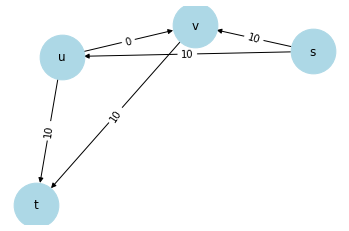

In [56]:
pos = nx.spring_layout(G)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=result_edges)
nx.draw(G, pos=pos, with_labels=True, node_color="lightblue", node_size=2_000)